In [2]:
# Импортируйте PyTorch и необходимые модули для работы с фреймворком
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
# Загрузите данные

X, Y = np.load("X_train.npy"), np.load("Y_train.npy")
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, Y_test = np.load("X_test.npy"), np.load("Y_test.npy")

# Создаем объекты TensorDataset
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(Y_val))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

# Создайте объекты DataLoader для ваших выборок
batch_size = 64

train_dataloader =  DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [4]:
# Напишите ответ какого ранга тензор, содержащий 1 пакет ваших данных и укажите размерности этого тензора

for batch in train_dataloader:
    images, labels = batch

    print("Ранг тензора:", torch.Tensor(X_train).ndim)
    print("Размерность тензора:", torch.Tensor(X_train).shape)

    break


Ранг тензора: 3
Размерность тензора: torch.Size([48000, 28, 28])


In [5]:
# Код для получения доступных устройств, которые потом можно задействовать при о
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()  # Для mps device enables high-performa
    else "cpu"
)
print(f"Используется {device}")


Используется cpu


In [6]:
# Напишите вашу реализацию NeuralNetwork для нейронной сети
# Не забудьте преобразовать ваши данные в одномерный тензор с помощью flatten()

# специально делаю плохую модель, чтобы потом её улучшить
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten().to(device)
        self.model = nn.Sequential(
            nn.Linear(28*28, 512).to(device),
            nn.Sigmoid().to(device),
            nn.Linear(512, 256).to(device),
            nn.Sigmoid().to(device),
            nn.Linear(256, 28).to(device),  # всего 28 разных чисел в датасете
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)


In [7]:
# Для экземпляра вашей нейронной сети можно использовать метод .to(device), чтоб
# Если вы используете .to(device) для модели, то не забудьте батчи и метки тоже

model = NeuralNetwork()
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=28, bias=True)
  )
)


In [8]:
# попробуйте сперва обучить модель с этими гиперпараметрами
learning_rate = 0.001
epochs = 5

# выбирите функцию потерь для вашей задачи
loss_fn = F.cross_entropy

# выбирите один из оптимизаторов и укажите подходящие параметры
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Переключим модель в режим обучния
    model.train()
    loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Вычислите предсказание, потери и метрики точности
        # Сохраните значение потерь и точности для построения графика
        pred = model(X)
        y = y.long()
        loss = loss_fn(pred, y)
        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (pred.argmax(dim=-1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss.item(), correct / size


def test_loop(dataloader, model, loss_fn):
    # Переключим модель в режим оценки
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # Оценка модели в контексте torch.no_grad() гарантирует, что в тестовом режи
    with torch.no_grad():
        for X, y in dataloader:
            # Напишите код для расчета предсказаний, потерь и метрики точности
            # Сохраните значение потерь и точности для построения графика
            pred = model(X)
            y = y.long()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=-1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")

    return test_loss, correct


In [10]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for t in range(epochs):
    print(f"Эпоха {t+1}")
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(val_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc.append(train_correct)
    test_losses.append(test_loss)
    test_acc.append(test_correct)


Эпоха 1
loss: 3.392489  [   64/48000]
loss: 0.596599  [ 6464/48000]
loss: 0.120908  [12864/48000]
loss: 0.058814  [19264/48000]
loss: 0.059619  [25664/48000]
loss: 0.074339  [32064/48000]
loss: 0.043330  [38464/48000]
loss: 0.036314  [44864/48000]
Test Error: 
 Accuracy: 99.9%
Эпоха 2
loss: 0.031355  [   64/48000]
loss: 0.030366  [ 6464/48000]
loss: 0.024095  [12864/48000]
loss: 0.021538  [19264/48000]
loss: 0.046450  [25664/48000]
loss: 0.014565  [32064/48000]
loss: 0.022020  [38464/48000]
loss: 0.021894  [44864/48000]
Test Error: 
 Accuracy: 98.2%
Эпоха 3
loss: 0.040167  [   64/48000]
loss: 0.045327  [ 6464/48000]
loss: 0.029864  [12864/48000]
loss: 0.020989  [19264/48000]
loss: 0.068864  [25664/48000]
loss: 0.054515  [32064/48000]
loss: 0.026965  [38464/48000]
loss: 0.030874  [44864/48000]
Test Error: 
 Accuracy: 99.0%
Эпоха 4
loss: 0.055634  [   64/48000]
loss: 0.028101  [ 6464/48000]
loss: 0.015866  [12864/48000]
loss: 0.018900  [19264/48000]
loss: 0.004055  [25664/48000]
loss: 0.

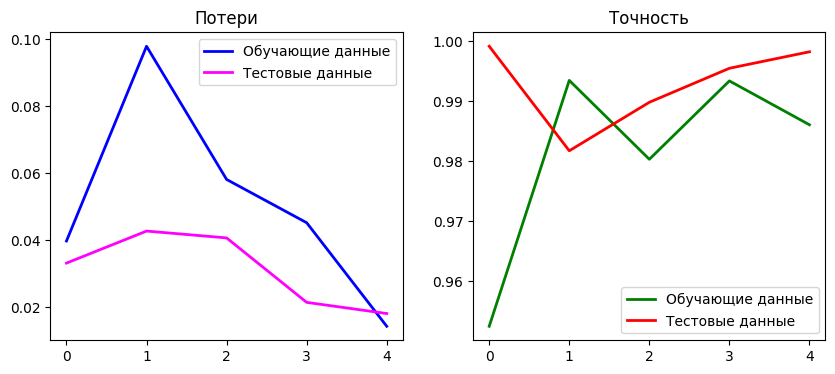

In [12]:

# Постройте графики потерь и точности на обучающей и валидационной выборках.
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.title('Потери')
plt.plot(train_losses, label='Обучающие данные', color='blue', linewidth=2)
plt.plot(test_losses, label='Тестовые данные', color='magenta', linewidth=2)
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Точность')
plt.plot(train_acc, label='Обучающие данные', color='green', linewidth=2)
plt.plot(test_acc, label='Тестовые данные', color='red', linewidth=2)
plt.legend()



## Запуск на тестовой выборке

In [23]:
test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

test_acc = test_correct
print('Точность на тестовой выборке: ', test_acc)


Test Error: 
 Accuracy: 99.1%, Avg loss: 0.025978 

Точность на тестовой выборке:  0.9914
